In [1]:
import pandas as pd
import numpy as np
import regex as re
import yfinance as yf
import pickle
import os
import datetime
import seaborn as sns
from matplotlib.pyplot import figure

## Correlation of Fidelity Funds
*Notebook by Peter Amerkhanian, 3/14/2022*

This notebook is an attempt to look at how different low cost Fidelity funds covary. Please note that this notebook is soley for education purposes and is not financial advice.
#### Data:
- `fidelity_funds.xlsx` 92 Fidelity funds that meet the following criteria:
    - No Transaction Fees, No minimum investment
    - below 0.75% net expense ratio
- `yfinance` API call that gathers historic returns for each fund

#### Question:
A typical investing strategy is to seek assets that are [countercyclical](https://www.investopedia.com/terms/c/countercyclicalstock.asp#:~:text=Counter%2Dcyclical%20stocks%20refer%20to,cyclical%20stocks%20will%20do%20well.) so as to mitigate portfolio risk during economic downturns. Given this, I'm curious which Fidelity funds are the most countercyclical, or, which are most inversely correlated with the returns of the stock market.

#### Methods:
I take the daily historical returns (in percent change) of a given group of Fidelity funds and calculate the correlation coefficient, $\rho$ between each fund and a baseline fund, `"FXAIX"`, which is a fund that seeks to mimic the S&P500.

For improved accuracy, I compute 95% confidence intervals of each $\rho_{fund, FXAIX}$ via bootstrapping

### Data Processing - `fidelity_funds.xlsx`

In [2]:
funds_df_raw = pd.read_excel("fidelity_funds.xlsx")

In [3]:
funds_df_raw.head()

,Name,Morningstar Category,YTD (Daily),1 Yr,3 Yr,5 Yr,10 Yr,Life of Fund,Expense Ratio - Net,Expense Ratio - Gross,Morningstar- Overall,Morningstar- 3yrs,Morningstar- 5yrs,Morningstar- 10yrs
0,Fidelity ZERO<sup>SM</sup> Extended Market Ind...,Mid-Cap Blend,-0.1035,2.67% (02/28/2022),12.84% (02/28/2022),-,-,9.45% (02/28/2022),0.00000,0.00000,2 (360 Rated),2 (360 Rated),-,-
1,Fidelity ZERO<sup>SM</sup> Large Cap Index Fun...,Large Blend,-0.1227,14.41% (02/28/2022),18.37% (02/28/2022),-,-,14.65% (02/28/2022),0.00000,0.00000,4 (1232 Rated),4 (1232 Rated),-,-
2,Fidelity ZERO<sup>SM</sup> Total Market Index ...,Large Blend,-0.1204,12.64% (02/28/2022),17.59% (02/28/2022),-,-,14.36% (02/28/2022),0.00000,0.00000,3 (1232 Rated),3 (1232 Rated),-,-
3,Fidelity 500 Index Fund (FXAIX),Large Blend,-0.1153,16.37% (02/28/2022),18.23% (02/28/2022),15.16% (02/28/2022),14.58% (02/28/2022),10.89% (02/28/2022),0.00015,0.00015,5 (1232 Rated),4 (1232 Rated),4 (1108 Rated),5 (819 Rated)
4,Fidelity Total Market Index Fund (FSKAX),Large Blend,-0.1220,11.94% (02/28/2022),17.43% (02/28/2022),14.60% (02/28/2022),14.20% (02/28/2022),8.63% (02/28/2022),0.00015,0.00015,4 (1232 Rated),3 (1232 Rated),3 (1108 Rated),4 (819 Rated)


In [4]:
# Extract ticker symbols from the "Name" field
funds_df_raw["Ticker"] = (funds_df_raw["Name"]
                          .str.extract(r"\(([A-Z]*)\)")
                          .astype(str))

In [5]:
# Drop any row without performance data from this year
funds_df = funds_df_raw.dropna(subset=["YTD (Daily)"])

### Data Retrieval from `yfinance`
This script returns comprehensive historical data for each fund then pickles that data. If the data has already been retrieved, the script will display the date/time of the last retrieval

In [6]:
if os.path.exists('fidelity_funds.pickle'):
    print("Fidelity fund info already retrieved @", 
          datetime.datetime.fromtimestamp(os.path.getctime('fidelity_funds.pickle')))
else:
    stocks = {}
    for ticker in funds_df["Ticker"]:
        stock = yf.Ticker(ticker)
        # get all market data
        hist = stock.history(period="max")
        stocks[ticker] = hist
        with open('fidelity_funds.pickle', 'wb') as f:
            pickle.dump(stocks, f)

Fidelity fund info already retrieved @ 2022-03-14 16:59:09.785354


### Processing `yfinance` data 

In [7]:
with open('fidelity_funds.pickle', 'rb') as f:
    stocks = pickle.load(f)

In [8]:
for stock_name, stock_data in stocks.items():
    stock_data['Pct_Change'] = stock_data['Close'].pct_change()

In [9]:
t = pd.concat(
    [df[["Pct_Change"]].rename(columns={"Pct_Change": name})
     for name, df in stocks.items()], 
    axis=1)

### Population Results
The following are the 5 Fidelity funds that are most uncorrelated with FXAIX, as measured by $\rho_i$ computed from all available data

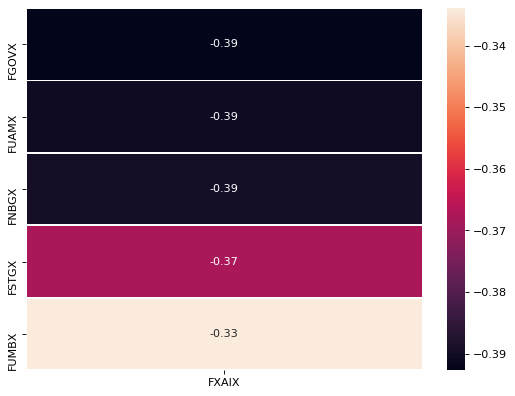

In [10]:
figure(figsize=(8, 6), dpi=80)
t_no_na = t.dropna(thresh=30)
sns.heatmap(t_no_na.corr()["FXAIX"].sort_values().to_frame().head(), annot=True, linewidths=.5);

### Bootstrap Code
In order to get a better idea of the variance of each of these $\rho_i$, I proceed to compute $95\%$ confidence intervals for each $\rho_i$. I sort these values by their $95th$ percentiles.
  
$H_0: \min(\rho) > 0$  
$H_A: \min(\rho) \leq 0$

In [11]:
baseline = "FXAIX"
boot_iter = 10000
sample_size = 100
confidence = 0.95
alpha = round((1-confidence)/2, 3)

bootstrap_results = pd.concat(
    [(
        t_no_na.sample(sample_size, replace=True)
        .corr()[baseline]
        .to_frame()
        .sort_values(by=baseline)
        .rename(columns={baseline: rep})
    )
     for rep in range(boot_iter)], axis=1).T

In [12]:
bottom_covariates = (bootstrap_results
                     .quantile(q=[alpha, .5, 1-alpha])
                     .T
                     .sort_values(by=1-alpha,
                                  ascending=True)
                     .head(20)
                    )

### Bootstrap Results
It would seem from this that at the $95\%$ confidence we cannot reject $H_0$ and need to conclude that none of these funds have statistically significant inverse correlation with `FXAIX`, though `FSTGX` is closest.

In [13]:
(
    pd.merge(bottom_covariates,
             funds_df[["Morningstar Category",
                       "Ticker",
                       "Life of Fund",
                       "Expense Ratio - Net"]],
             left_index=True, right_on="Ticker"
            )
    .reset_index().drop("index", axis=1))

,0.025,0.5,0.975,Morningstar Category,Ticker,Life of Fund,Expense Ratio - Net
0,-0.696206,-0.358844,0.009364,Intermediate Government,FSTGX,4.67% (02/28/2022),0.00450
1,-0.726411,-0.389522,0.046849,Intermediate Government,FGOVX,6.52% (02/28/2022),0.00450
2,-0.598996,-0.286180,0.062447,Short Government,FFXSX,4.36% (02/28/2022),0.00450
3,-0.638254,-0.310460,0.210773,Intermediate Core Bond,FXNAX,5.57% (02/28/2022),0.00025
4,-0.491913,-0.159057,0.240236,Intermediate Government,FGMNX,5.64% (02/28/2022),0.00450
5,-0.816927,-0.367432,0.263681,Intermediate Government,FUAMX,4.08% (02/28/2022),0.00030
6,-0.774599,-0.318002,0.283501,Short Government,FUMBX,2.36% (02/28/2022),0.00030
7,-0.590900,-0.154281,0.297783,Inflation-Protected Bond,FIPDX,2.63% (02/28/2022),0.00050
8,-0.583328,-0.264394,0.301289,Intermediate Core Bond,FTHRX,6.74% (02/28/2022),0.00450
9,-0.831357,-0.369764,0.301490,Long Government,FNBGX,5.86% (02/28/2022),0.00030
